In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV

sns.set_palette('hls')
default_path = 'C:/Users/zcxu/Downloads/titanic/'

### data visualization and preparatory data analysis

In [ ]:
train_df = pd.read_csv(default_path+'train.csv')
test_df = pd.read_csv(default_path+'test.csv')

In [48]:
dataset_df = pd.concat([train_df, test_df]).reset_index(drop=True)
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


E:\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [49]:
train_df[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Survived
Sex,
female,0.742038
male,0.188908


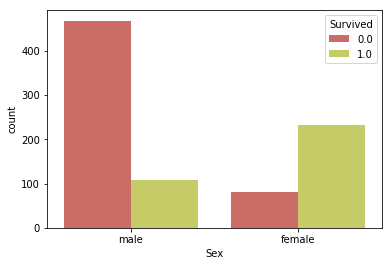

In [50]:
sns.countplot('Sex', hue='Survived', data=dataset_df)
dataset_df[['Sex', 'Survived']].groupby('Sex').mean()

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363


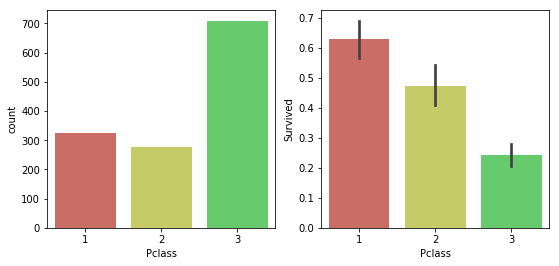

In [51]:
print(dataset_df[['Pclass', 'Survived']].groupby('Pclass').mean())
fig, [ax, ax1] = plt.subplots(1, 2)
fig.set_size_inches(9, 4)
sns.countplot(x='Pclass', data=dataset_df, ax=ax)
g = sns.factorplot('Pclass', 'Survived', data=dataset_df, kind='bar', ax=ax1)
plt.close(g.fig)

          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.336957


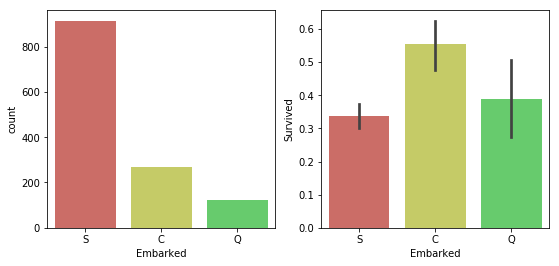

In [52]:
print(dataset_df[['Embarked', 'Survived']].groupby('Embarked').mean())
fig, [ax, ax1] = plt.subplots(1, 2)
fig.set_size_inches(9, 4)
sns.countplot('Embarked', data=dataset_df, ax=ax)
g = sns.factorplot('Embarked', 'Survived', data=dataset_df, kind='bar', ax=ax1)
plt.close(g.fig)

E:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


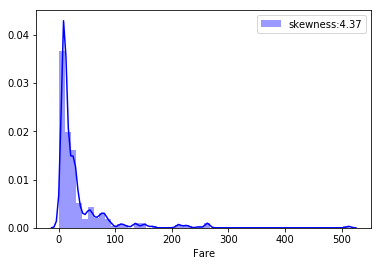

In [53]:
dataset_df['Fare'] = dataset_df['Fare'].fillna(dataset_df['Fare'].median())
sns.distplot(dataset_df['Fare'], color='b', label='skewness:%.2f'%dataset_df['Fare'].skew()).legend(loc='best')

       Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000
9           NaN


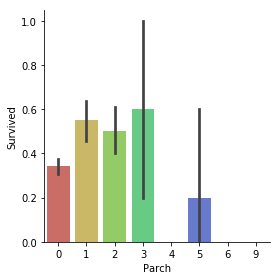

In [54]:
print(dataset_df[['Parch', 'Survived']].groupby('Parch').mean())
sns.factorplot('Parch', 'Survived', data = dataset_df, kind='bar', palette='hls')

E:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
E:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


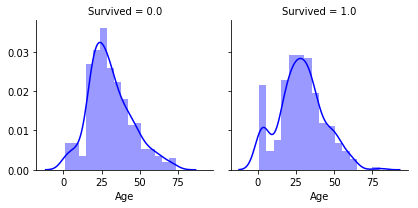

In [55]:
sns.FacetGrid(data=dataset_df, col='Survived').map(sns.distplot, 'Age', color='b')

### Feature Engineering

E:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


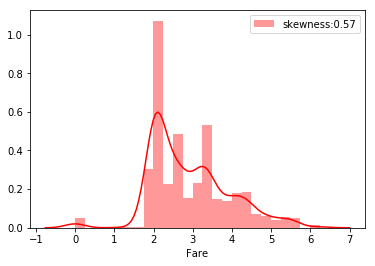

In [56]:
# make log for 'Fare' feature in order to decrease skewness
dataset_df['Fare'] = dataset_df['Fare'].map(lambda i: np.log(i) if i>0 else 0)
sns.distplot(dataset_df['Fare'], color='r', label='skewness:%.2f'%dataset_df['Fare'].skew()).legend(loc='best')

            Survived
FareBins_4          
0           0.197309
1           0.303571
2           0.441048
3           0.600000
            Survived
FareBins_5          
0           0.217877
1           0.201087
2           0.426901
3           0.443243
4           0.645349
            Survived
FareBins_6          
0           0.205128
1           0.190789
2           0.366906
3           0.436242
4           0.435065
5           0.695035


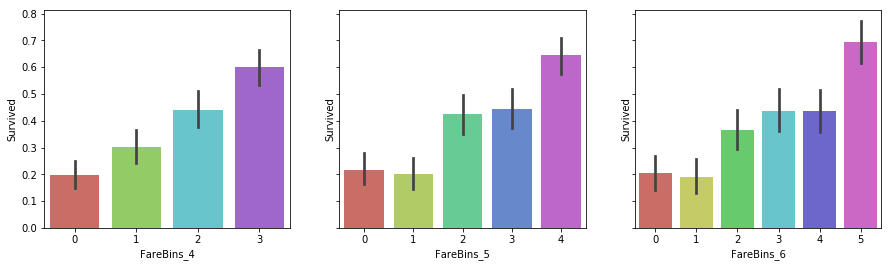

In [57]:
# doing bins_cut for 'Fare' feature
# we do not know which bins_cuts is better, so we do RFE latter(in feature selection part)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 4)

for q, ax in zip([4, 5, 6], [ax1, ax2, ax3]):
    diff_fare_bin_names = 'FareBins_'+str(q)
    fare_bins = pd.qcut(dataset_df['Fare'], q=q, labels=False)
    dataset_df[diff_fare_bin_names] = pd.DataFrame(fare_bins)
    print(dataset_df[[diff_fare_bin_names, 'Survived']].groupby(diff_fare_bin_names).mean())
    # factorplot will generate another fig automatically, we we turn it off
    g = sns.factorplot(diff_fare_bin_names, 'Survived', data=dataset_df, kind='bar', palette='hls', ax=ax)
    plt.close(g.fig)

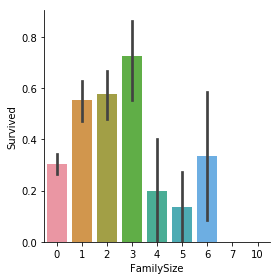

In [58]:
dataset_df['FamilySize'] = dataset_df['Parch'] + dataset_df['SibSp']
sns.factorplot('FamilySize', 'Survived',data=dataset_df, kind='bar')

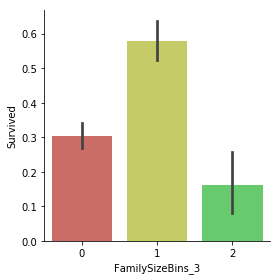

In [59]:
# doing bins_cut for 'FamilySize' feature
bins= [-1, 0, 3, 10]
dataset_df['FamilySizeBins_3'] = pd.cut(dataset_df['FamilySize'], bins=bins, labels=False)
sns.factorplot('FamilySizeBins_3', 'Survived', data=dataset_df, kind='bar')

In [60]:
dataset_df['Sex'] = dataset_df['Sex'].map({'male':0, 'female':1})

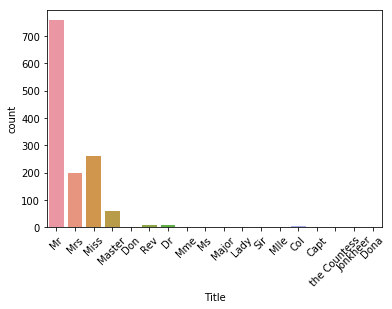

In [61]:
dataset_df['Title'] = pd.DataFrame([i.split(",")[1].split(".")[0].strip() for i in dataset_df['Name']])
g = sns.countplot(dataset_df['Title'])
g = plt.setp(g.get_xticklabels(), rotation=45)

['Mr' 'Mrs' 'Miss' 'Master' 'Rare' 'Capt' 'Jonkheer']


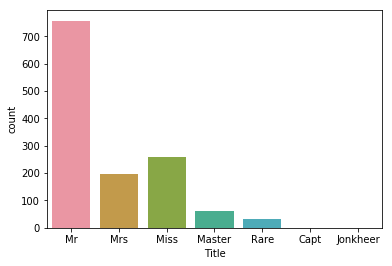

In [62]:
dataset_df['Title'] = dataset_df['Title'].replace(['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir',
                                                  'Mlle', 'Col', 'the Countess', 'Jonkherr', 'Dona'], 'Rare')
print(dataset_df['Title'].unique())
sns.countplot(dataset_df['Title'])

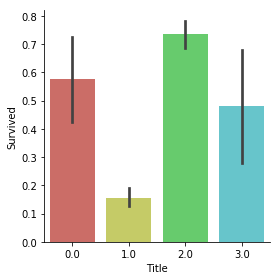

In [63]:
dataset_df['Title'] = dataset_df['Title'].map({'Master': 0, 'Mr':1, 'Miss':2, 'Mrs':2, 'Rare':3})
sns.factorplot('Title', 'Survived', data=dataset_df, kind='bar')

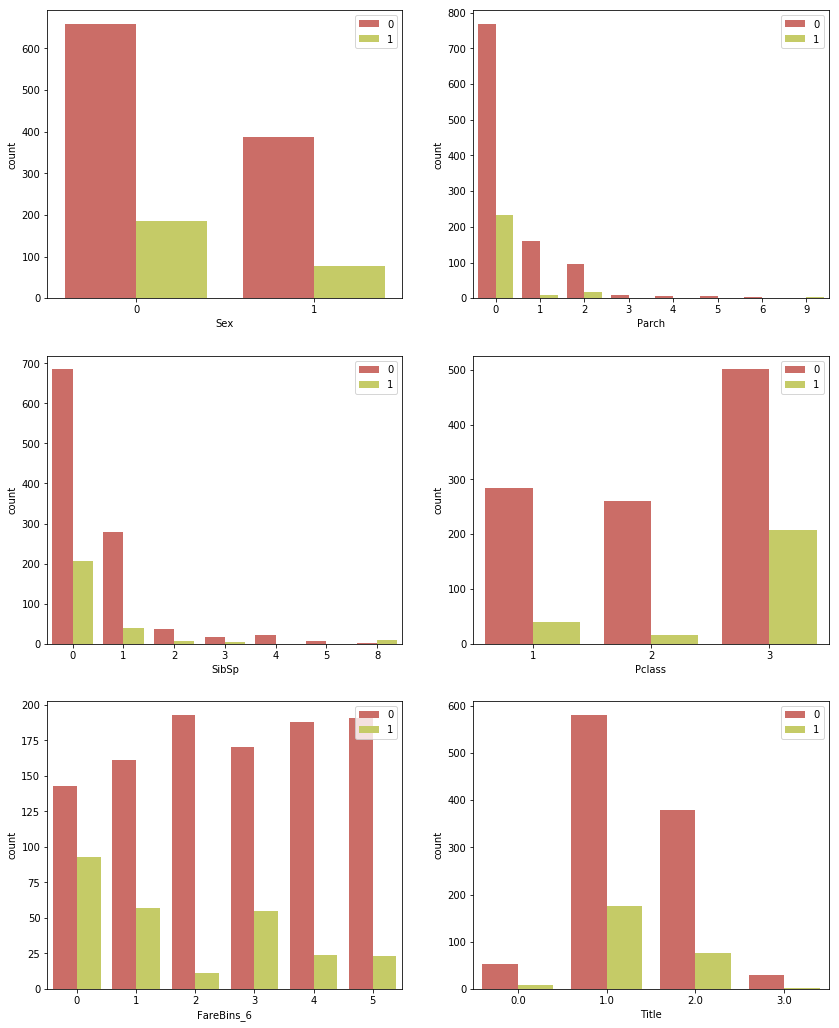

In [64]:
# observe the fact that missing value of age maybe cause inbalance data distribution
dataset_df['HasAge'] = dataset_df['Age'].isnull().map(lambda i: 1 if i== True else 0)
fig, [ax, ax1, ax2] = plt.subplots(3, 2)
fig.set_size_inches(14, 18)
sns.countplot('Sex', hue='HasAge', data=dataset_df, ax = ax[0]).legend(loc=1)
sns.countplot('Parch', hue='HasAge', data=dataset_df, ax = ax[1]).legend(loc=1)
sns.countplot('SibSp', hue='HasAge', data=dataset_df, ax = ax1[0]).legend(loc=1)
sns.countplot('Pclass', hue='HasAge', data=dataset_df, ax = ax1[1]).legend(loc=1)
sns.countplot('FareBins_6', hue='HasAge', data=dataset_df, ax = ax2[0]).legend(loc=1)
sns.countplot('Title', hue='HasAge', data=dataset_df, ax = ax2[1]).legend(loc=1)

### In the following part, I implemented feature engineering from another perspective. For the engineering part, many people do not pay enough attention on it. But it is rather important in the whole modeling process. The output not only depends on which model you selected, but also depends on how you construct the features, how well you understand the whole dataset. In my opinion, feature engineering is the most important part in kaggle contest. If you would like to get a better score, read kernels written by others, and think about how you could improve your feature engineering work

In [65]:
# NumPy
import numpy as np

# Dataframe operations
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Models
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.linear_model import Perceptron
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

### As you can see, I used many models in this dataset, and K-Nearest-Neighbors got the best performance. It's easy to understand, less time-consuming, and suitable for my current feature engineering work.

In [66]:
train_df = pd.read_csv(default_path+'train.csv')
test_df = pd.read_csv(default_path+'test.csv')

data_df = train_df.append(test_df)

E:\anaconda\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [67]:
data_df['Title'] = data_df['Name']
# Cleaning name and extracting Title
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute
    
# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Age'] = data_df['Age'][:891]
test_df['Age'] = data_df['Age'][891:]

# Dropping Title feature
data_df.drop('Title', axis = 1, inplace = True)

In [68]:
data_df['Family_Size'] = data_df['Parch'] + data_df['SibSp']

# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Family_Size'] = data_df['Family_Size'][:891]
test_df['Family_Size'] = data_df['Family_Size'][891:]

data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [69]:
for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train_df['Family_Survival'] = data_df['Family_Survival'][:891]
test_df['Family_Survival'] = data_df['Family_Survival'][891:]

Number of passenger with family/group survival information: 546


In [70]:
data_df['Fare'].fillna(data_df['Fare'].median(), inplace = True)

# Making Bins
data_df['FareBin'] = pd.qcut(data_df['Fare'], 5)

label = LabelEncoder()
data_df['FareBin_Code'] = label.fit_transform(data_df['FareBin'])

train_df['FareBin_Code'] = data_df['FareBin_Code'][:891]
test_df['FareBin_Code'] = data_df['FareBin_Code'][891:]

train_df.drop(['Fare'], 1, inplace=True)
test_df.drop(['Fare'], 1, inplace=True)

In [71]:
data_df['AgeBin'] = pd.qcut(data_df['Age'], 4)

label = LabelEncoder()
data_df['AgeBin_Code'] = label.fit_transform(data_df['AgeBin'])

train_df['AgeBin_Code'] = data_df['AgeBin_Code'][:891]
test_df['AgeBin_Code'] = data_df['AgeBin_Code'][891:]

train_df.drop(['Age'], 1, inplace=True)
test_df.drop(['Age'], 1, inplace=True)

In [72]:
train_df['Sex'].replace(['male','female'],[0,1],inplace=True)
test_df['Sex'].replace(['male','female'],[0,1],inplace=True)

train_df.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked'], axis = 1, inplace = True)
test_df.drop(['Name','PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
              'Embarked'], axis = 1, inplace = True)

In [73]:
X = train_df.drop('Survived', 1)
y = train_df['Survived']
X_test = test_df.copy()

std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)

In [74]:
n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc")
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
0.879492358564122
KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='uniform')


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:   30.9s finished


In [75]:
gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(X_test)

In [76]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')
knn.fit(X, y)
y_pred = knn.predict(X_test)

In [78]:
temp = pd.DataFrame(pd.read_csv(default_path+ "test.csv")['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv("submission.csv", index = False)